In [16]:
import pennylane as qml
import pennylane.numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl

## QWC

We will work with these two observables
$$X \otimes Y \otimes \text{Id} \qquad \text{and} \qquad X \otimes \text{Id} \otimes Z$$

In [17]:
obs = [
    qml.PauliX(0) @ qml.PauliY(1),
    qml.PauliX(0) @ qml.PauliZ(2)
]

We can first use two separate circuit evaulations to measure each term.

In [18]:
dev = qml.device("default.qubit", wires=3)

@qml.qnode(dev)
def circuit1(weights):
    qml.StronglyEntanglingLayers(weights, wires=range(3))
    return qml.expval(obs[0])


@qml.qnode(dev)
def circuit2(weights):
    qml.StronglyEntanglingLayers(weights, wires=range(3))
    return qml.expval(obs[1])

shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=3)
weights = np.random.random(size=shape)

print("Expectation value of X@Y@I =", circuit1(weights))
print("Expectation value of X@I@Z =", circuit2(weights))

Expectation value of X@Y@I = 0.1727636412450899
Expectation value of X@I@Z = -0.4381380454832621


In [19]:
# print(qml.draw(circuit1, level="device")(weights))

Now, we use our QWC approach to reduce this down to a single measurement of the probabilities in the shared eigenbasis of both QWC observables

In [20]:
@qml.qnode(dev)
def circuit_qwc(weights):
    qml.StronglyEntanglingLayers(weights, wires=range(3))
    
    # rotate qubit 0 into shared eigenbasis (in this case, X basis)
    qml.RY(-np.pi/2, wires=0)
    
    # rotate qubit 1 into shared eigenbasis (in this case, Y basis)
    qml.RX(np.pi/2, wires=1)
    
    # qubit 2 requires no action
    
    # measure probabilities in the computational basis
    return qml.probs(wires=range(3))

rotated_probs = circuit_qwc(weights)
print(rotated_probs)

[0.07513091 0.02707783 0.1612447  0.04328099 0.17232553 0.03676696
 0.47638467 0.0077884 ]


We're not quite there yet; we have only calculated the probabilities of the variational circuit rotated into the shared eigenbasis (the $|\langle\psi_i|{\Psi}\rangle|^2$). To recover the expectation values of the two QWC observables from the probabilities, we need one final piece of information: their eigenvalues $\lambda^{(A)}_i$ and $\lambda^{(B)}_i$.

Pauli operators have eigenvalues $\pm 1$ and the identity has just 1 as eigenvalue.

In [21]:
eigenvalues_XYI = np.kron(np.kron(np.array([1, -1]), np.array([1, -1])), np.array([1, 1]))
eigenvalues_XIZ = np.kron(np.kron(np.array([1, -1]), np.array([1, 1])), np.array([1, -1]))

In [22]:
print("Expectation value of XYI = ", np.dot(eigenvalues_XYI, rotated_probs))
print("Expectation value of XIZ = ", np.dot(eigenvalues_XIZ, rotated_probs))

Expectation value of XYI =  0.17276364124508994
Expectation value of XIZ =  -0.438138045483262


## Grouping QWC terms

Say we have the following Hamiltonian
$$
H = Z_0 + Z_0Z_1 + Z_0Z_1Z_2 + Z_0Z_1Z_2Z_3 + X_2X_3 + Y_0X_2X_3 + Y_0Y_1X_2X_3
$$
where, for brevitiy, we use the notation $P_0P_2$ to mean $P\otimes \text{Id} \otimes P \otimes \text{Id}$. Since QWC is a reflexive and symmetric relation, we can represent QWC terms of $H$ as the following graph

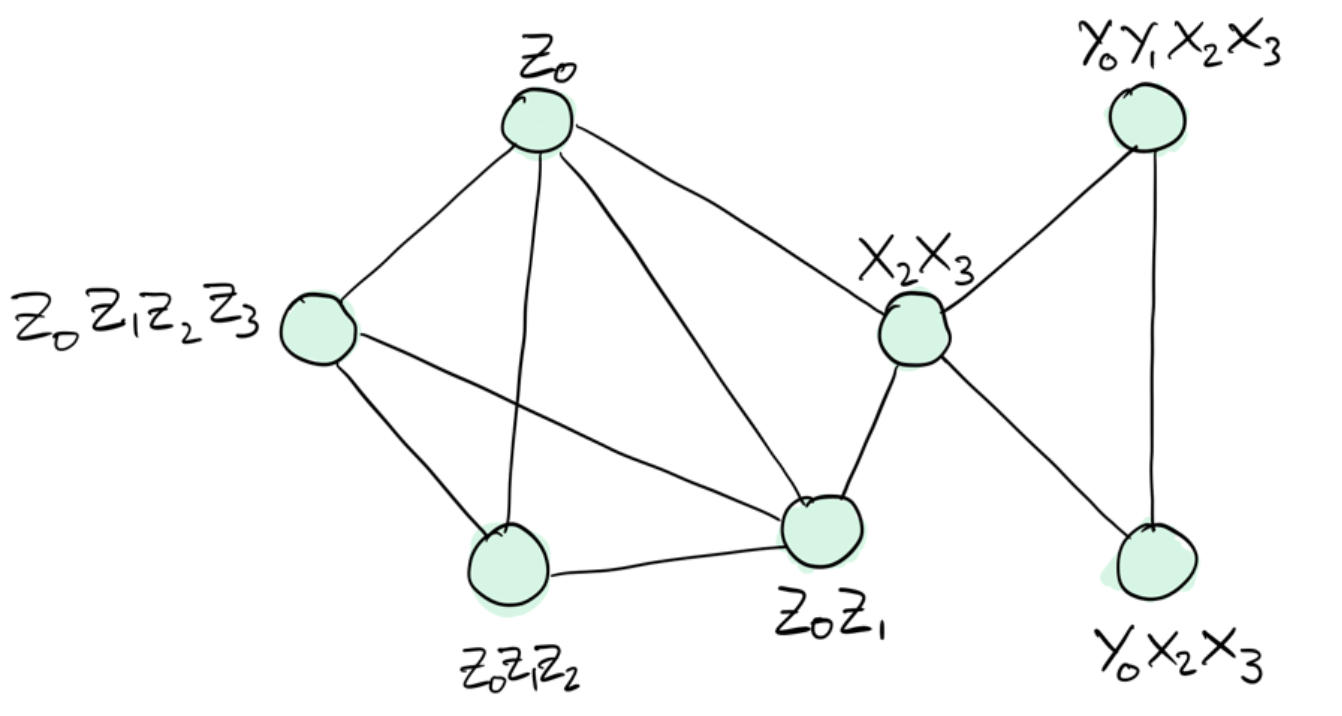

where two vertices (which are the $h^{(i)}$) are connected if and only if they QWC. Grouping is looking for cliques of this graph. There are many possibilities:

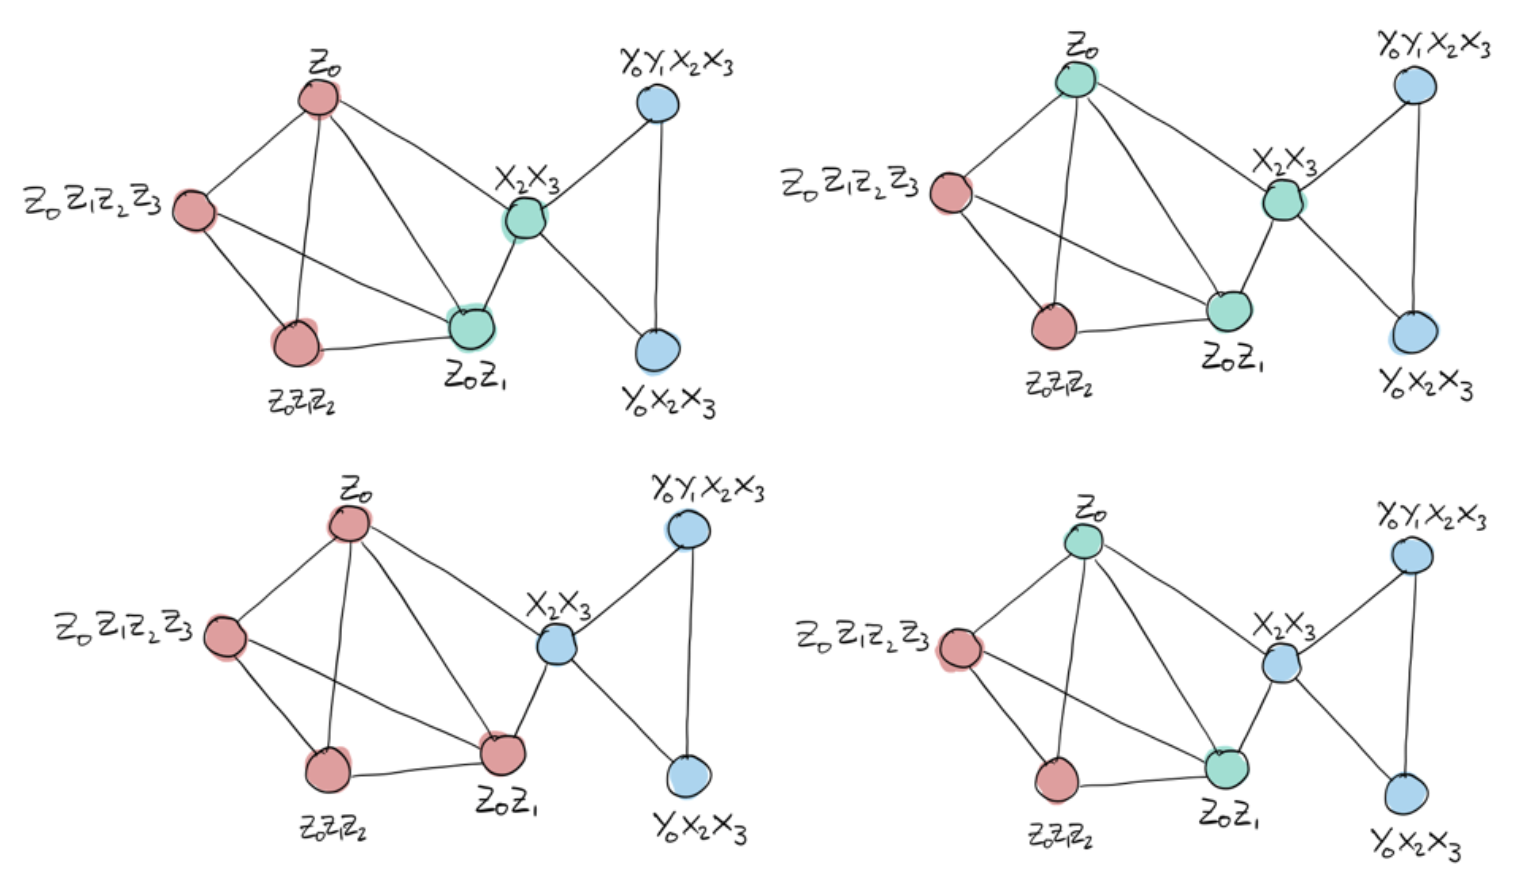

but the optimal one is the bottom-left one, which partitions our graph into two complete subgraphs. This means that we could calculate the expectation value of the Hamiltonian with only two circuit measurements.

Thus, we have to find the **Minimum Clique Cover (MCC)** of our graph, which is known to be an NP-hard problem: no known (classical) solution to finding the optimum/minimum clique cover in polynomial time.

We can equivalently view our MCM task as a graph-colouring problem. If we consider the complement graph of our original graph, where two vertices are joined iff they do not QWC, then a colouring of this complement graph (with the least number of colours possible) will give us a MCC.

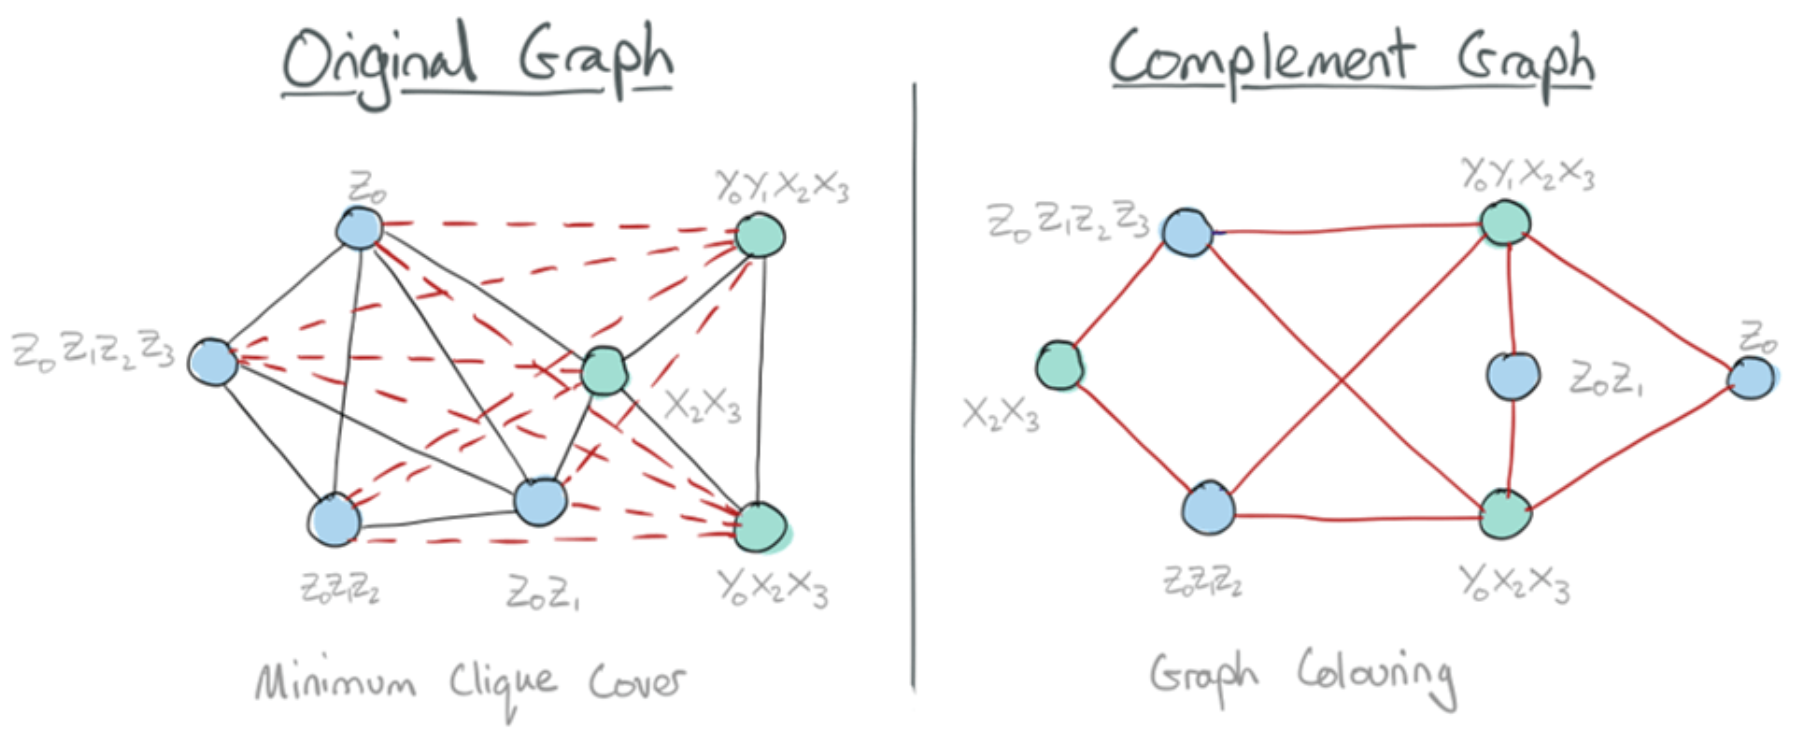

In [23]:
# terms of our Hamiltonian H
terms = [
    qml.PauliZ(0),
    qml.PauliZ(0) @ qml.PauliZ(1),
    qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2),
    qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3),
    qml.PauliX(2) @ qml.PauliX(3),
    qml.PauliY(0) @ qml.PauliX(2) @ qml.PauliX(3),
    qml.PauliY(0) @ qml.PauliY(1) @ qml.PauliX(2) @ qml.PauliX(3)
]

def format_pauli_word(term):
    """Convenience function that nicely formats a PennyLane
    tensor observable as a Pauli word"""
    # check if term is product of Paulis
    if isinstance(term, qml.ops.Prod):
        return " ".join([format_pauli_word(t) for t in term])

    return f"{term.name[-1]}{term.wires.tolist()[0]}"

We now create our graph

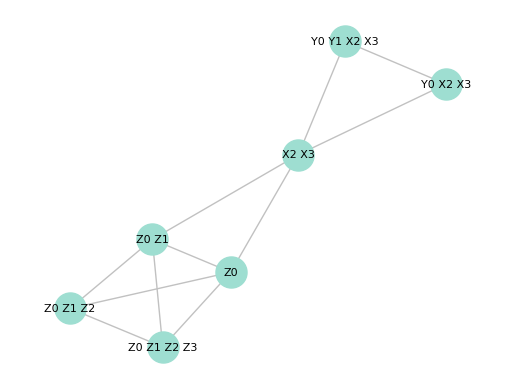

In [24]:
G = nx.Graph()

G.add_nodes_from(terms)
G.add_edges_from([
        [terms[0], terms[1]],  # Z0 <--> Z0 Z1
        [terms[0], terms[2]],  # Z0 <--> Z0 Z1 Z2
        [terms[0], terms[3]],  # Z0 <--> Z0 Z1 Z2 Z3
        [terms[1], terms[2]],  # Z0 Z1 <--> Z0 Z1 Z2
        [terms[2], terms[3]],  # Z0 Z1 Z2 <--> Z0 Z1 Z2 Z3
        [terms[1], terms[3]],  # Z0 Z1 <--> Z0 Z1 Z2 Z3
        [terms[0], terms[4]],  # Z0 <--> X2 X3
        [terms[1], terms[4]],  # Z0 Z1 <--> X2 X3
        [terms[4], terms[5]],  # X2 X3 <--> Y0 X2 X3
        [terms[4], terms[6]],  # X2 X3 <--> Y0 Y1 X2 X3
        [terms[5], terms[6]],  # Y0 X2 X3 <--> Y0 Y1 X2 X3
])

plt.margins(x=0.1)
coords = nx.spring_layout(G, seed=1) # positions for all nodes to display them better
nx.draw(
    G,
    coords,
    labels={node: format_pauli_word(node) for node in terms},
    with_labels=True,
    node_size=500,
    font_size=8,
    node_color="#9eded1",
    edge_color="#c1c1c1",
)

We can then create our complement graph and colour it

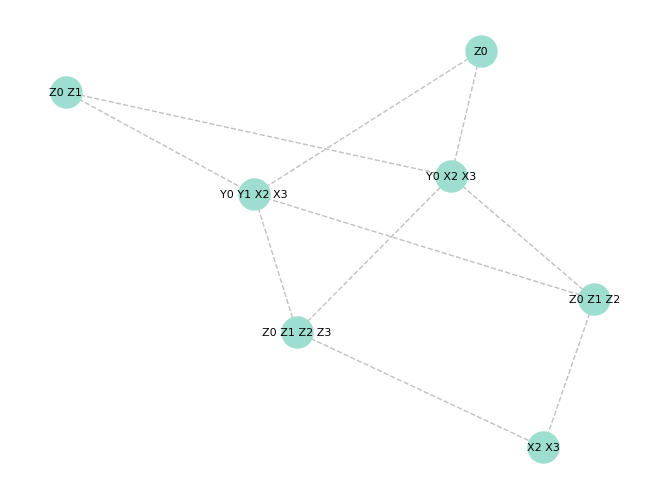

In [25]:
C = nx.complement(G)
coord = nx.spring_layout(C, seed=1)

nx.draw(
    C,
    coord,
    labels={node: format_pauli_word(node) for node in terms},
    with_labels=True,
    node_size=500,
    font_size=8,
    node_color="#9eded1",
    edge_color="#c1c1c1",
    style="dashed"
)  

We can then use the greedy colouring algorithm in the complement graph

<class 'dict'>
{Y(0) @ X(2) @ X(3): 0, Y(0) @ Y(1) @ X(2) @ X(3): 0, Z(0) @ Z(1) @ Z(2): 1, Z(0) @ Z(1) @ Z(2) @ Z(3): 1, Z(0): 1, Z(0) @ Z(1): 1, X(2) @ X(3): 0}
Minimum number of QWC groupings found: 2

Group 0:
Y0 X2 X3
Y0 Y1 X2 X3
X2 X3

Group 1:
Z0 Z1 Z2
Z0 Z1 Z2 Z3
Z0
Z0 Z1


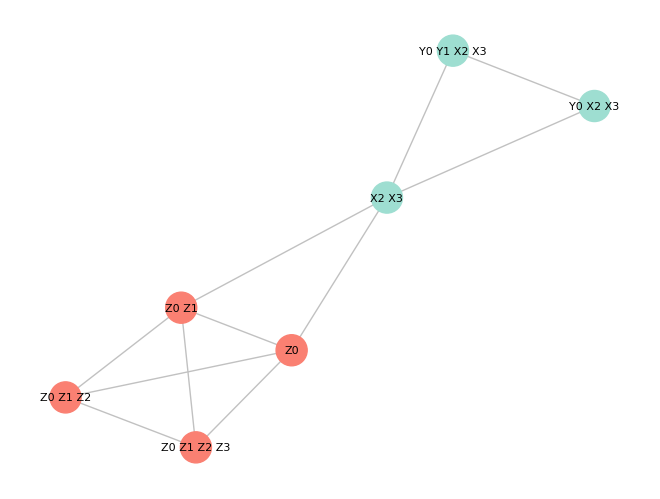

In [26]:
groups = nx.coloring.greedy_color(C, strategy="largest_first")
print(type(groups))
print(groups)

nx.draw(
    G,
    coords,
    labels={node: format_pauli_word(node) for node in terms},
    with_labels=True,
    node_size=500,
    font_size=8,
    node_color=[("#9eded1", "#FA8072")[groups[node]] for node in C],
    edge_color="#c1c1c1"
)

num_groups = len(set(groups.values()))
print("Minimum number of QWC groupings found:", num_groups)

for i in range(num_groups):
    print(f"\nGroup {i}:")
    for term, group_id in groups.items():
        if group_id == i:
            print(format_pauli_word(term))

We can now optimize this using PennyLane's built-in functions.

In [27]:
def plot_qwc_graph(terms, groupings={}):
    """
    Function to create a graph of the QWC terms of the Hamiltonian.
    
    Args:
        terms (list): List of terms of the Hamiltonian.
        groupings (dict): Dictionary of groupings for the terms.
    Returns:
        None
    """
    G = nx.Graph()
    G.add_nodes_from(terms)
    
    for i in range(len(terms)):
        for j in range(i, len(terms)):
            if i != j and qml.pauli.are_pauli_words_qwc([terms[i], terms[j]]):
                G.add_edge(terms[i], terms[j])
    
    colors = mpl.colormaps['Set2'].colors
    if groupings:
        node_colors = [colors[groupings[node]] for node in G]
    else:
        node_colors = [colors[0]] * len(G.nodes())
    
    plt.margins(x=0.1)
    coords = nx.spring_layout(G, seed=1) # positions for all nodes to display them better
    nx.draw(
        G,
        coords,
        labels={node: format_pauli_word(node) for node in terms},
        with_labels=True,
        node_size=500,
        font_size=8,
        node_color=node_colors,
        edge_color="#c1c1c1",
    )
    plt.show()


def qwc_groups_to_dict(groupings):
    """
    Convert the groupings from the QML format to a dictionary format.
    """
    groupings_dict = {}
    for i, group in enumerate(groupings):
        for term in group:
            groupings_dict[term] = i
    return groupings_dict

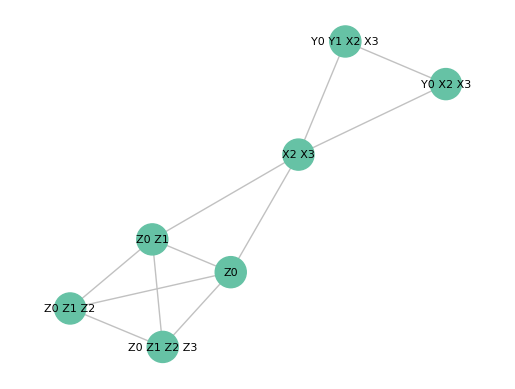

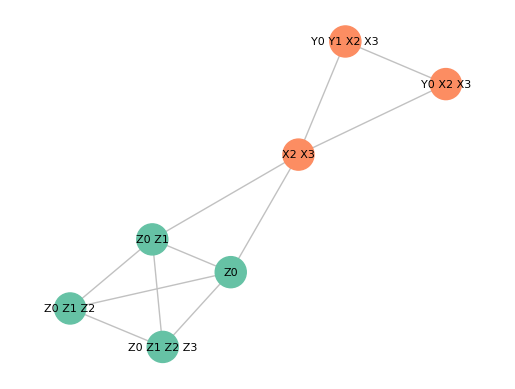

In [28]:
# terms of our Hamiltonian H
terms = [
    qml.PauliZ(0),
    qml.PauliZ(0) @ qml.PauliZ(1),
    qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2),
    qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3),
    qml.PauliX(2) @ qml.PauliX(3),
    qml.PauliY(0) @ qml.PauliX(2) @ qml.PauliX(3),
    qml.PauliY(0) @ qml.PauliY(1) @ qml.PauliX(2) @ qml.PauliX(3)
]

# plot the QWC graph
plot_qwc_graph(terms)

# find the QWC groupings
qwc_groupings = qml.pauli.group_observables(terms, grouping_type="qwc")
plot_qwc_graph(terms, qwc_groups_to_dict(qwc_groupings))

With these groups, we can now compute the common eigenbasis of each group

In [29]:
rotations, measurements = qml.pauli.diagonalize_qwc_groupings(qwc_groupings)

In [30]:
rotations

[[],
 [RY(-1.5707963267948966, wires=[2]),
  RY(-1.5707963267948966, wires=[3]),
  RX(1.5707963267948966, wires=[0]),
  RX(1.5707963267948966, wires=[1])]]

In [31]:
measurements

[[Z(0), Z(0) @ Z(1), Z(0) @ Z(1) @ Z(2), Z(0) @ Z(1) @ Z(2) @ Z(3)],
 [Z(2) @ Z(3), Z(0) @ Z(2) @ Z(3), Z(0) @ Z(1) @ Z(2) @ Z(3)]]

In [32]:
H = qml.Hamiltonian(coeffs=np.ones(len(terms)), observables=terms)

dev = qml.device("default.qubit", wires=4)

@qml.qnode(dev)
def circuit(weights, group=None):
    qml.StronglyEntanglingLayers(weights, wires=range(4))
    return [qml.expval(o) for o in group]

@qml.qnode(dev)
def cost_fn(weights):
    qml.StronglyEntanglingLayers(weights, wires=range(4))
    return qml.expval(H)

shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=4)
weights = np.random.random(size=shape)

result = [np.array(circuit(weights, group=g)) for g in qwc_groupings]

print("Term expectation values:")
for group, expvals in enumerate(result):
    print(f"Group {group} expectation values:", expvals)

# Since all the coefficients of the Hamiltonian are unity,
# we can simply sum the expectation values.)
print("Grouping estimation: \n\t<H> =", np.sum(np.hstack(result)))
print("Raw estimation: \n\t<H> =", cost_fn(weights))

Term expectation values:
Group 0 expectation values: [0.81620029 0.8991616  0.94191303 0.90509861]
Group 1 expectation values: [-0.00727114  0.05894156  0.00520426]
Grouping estimation: 
	<H> = 3.619248216172817
Raw estimation: 
	<H> = 3.619248216172817


In [33]:
@qml.qnode(dev)
def group_circuit(weights, group=None):
    qml.StronglyEntanglingLayers(weights, wires=range(4))
    for rotation in rotations[group]:
        qml.apply(rotation)
    return [qml.expval(o) for o in measurements[group]]


grouping_results = [np.array(group_circuit(weights, group=group)) for group in range(len(qwc_groupings))]

print("Grouping term expectation values:")
for group, expvals in enumerate(grouping_results):
    print(f"Group {group} expectation values:", expvals)
# for group, expvals in enumerate(result):
#     print(f"Group {group} expectation values:", expvals)

Grouping term expectation values:
Group 0 expectation values: [0.81620029 0.8991616  0.94191303 0.90509861]
Group 1 expectation values: [-0.00727114  0.05894156  0.00520426]
